In [322]:
from qiskit import *
from qiskit.circuit import Parameter
import numpy as np
from itertools import combinations
from qiskit.quantum_info import state_fidelity as distance
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Following implementataion of https://journals.aps.org/prx/pdf/10.1103/PhysRevX.7.021050 and https://arxiv.org/pdf/1804.03023.pdf for the calculation of $A$ and $C$

I am using single qubit variational gates as I have not yet figures out how it works for 2 qubit gates. Some details are there in the SM but I have to look closer at those

In [11]:
def get_circuit_simple(n,lm=None):
    anc=QuantumRegister(1,"ancilla")
    basis=QuantumRegister(n,"basis")
    meassure=ClassicalRegister(1,"meassure")
    set_ancila=1
    if lm==None:
        set_ancila=0
        lm=[-1,-1]
    if set_ancila:
        circ = QuantumCircuit(anc,basis,meassure)
        circ.h(anc)
    else:
        circ = QuantumCircuit(basis)

    circ.h(basis)
    circ.barrier()
    combi=list(combinations(range(n),2))
    theta = [Parameter(f't-{i}') for i in range(len(combi))]
    cnt=0
    for j,i in enumerate(combi):
        if cnt == lm[0]:
            circ.x(anc)
            circ.cx(anc,basis[i[1]])
            circ.x(anc)
        if cnt == lm[1]:
            circ.cx(anc,basis[i[1]])
        circ.cry(theta[cnt],basis[i[0]],basis[i[1]])
        cnt+=1
    circ.barrier()

    if set_ancila:
        circ.h(anc)
        circ.measure(anc,meassure)
    return circ

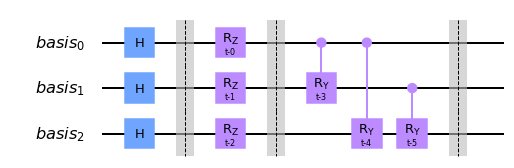

In [29]:
def get_circuit(n,lm=None):
    anc=QuantumRegister(1,"ancilla")
    basis=QuantumRegister(n,"basis")
    meassure=ClassicalRegister(1,"meassure")
    set_ancila=1
    if lm==None:
        set_ancila=0
        lm=[-1,-1]
    if set_ancila:
        circ = QuantumCircuit(anc,basis,meassure)
        circ.h(anc)
    else:
        circ = QuantumCircuit(basis)

    circ.h(basis)
    circ.barrier()
    combi=list(combinations(range(n),2))
    theta = [Parameter(f't-{i}') for i in range(len(combi)+n)]
    cnt=0
    for i in range(n):
        if cnt == lm[0]:
            circ.x(anc)
            circ.cx(anc,basis[i])
            circ.x(anc)
        if cnt == lm[1]:
            circ.cx(anc,basis[i])
        circ.rz(theta[cnt],basis[i])
        cnt+=1
    circ.barrier()
    for j,i in enumerate(combi):
        if cnt == lm[0]:
            circ.x(anc)
            circ.cx(anc,basis[i[1]])
            circ.x(anc)
        if cnt == lm[1]:
            circ.cx(anc,basis[i[1]])
        circ.cry(theta[cnt],basis[i[0]],basis[i[1]])
        cnt+=1
    circ.barrier()

    if set_ancila:
        circ.h(anc)
        circ.measure(anc,meassure)
    return circ
c=get_circuit(3)
c.draw('mpl')

In [79]:
def get_lm(circ,angles):
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    circ_params_wo_meassure=circ_params.remove_final_measurements(inplace=False)
    statevector=get_final_state(circ_params_wo_meassure)
    a=np.real(statevector*statevector.conj())
    return 1-a[0::2].sum()
def get_final_state(circ_params_wo_meassure):
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(circ_params_wo_meassure, simulator).result()
    statevector = result.get_statevector(circ_params_wo_meassure)
    return statevector
def get_cost(angles,circ,compare):
    from qiskit.quantum_info import state_fidelity as distance
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    a=get_final_state(circ_params)
    # return np.abs(np.real(a@compare.T))
    return np.arccos(distance(a,compare))
    # return 2*(1-distance(a,compare))

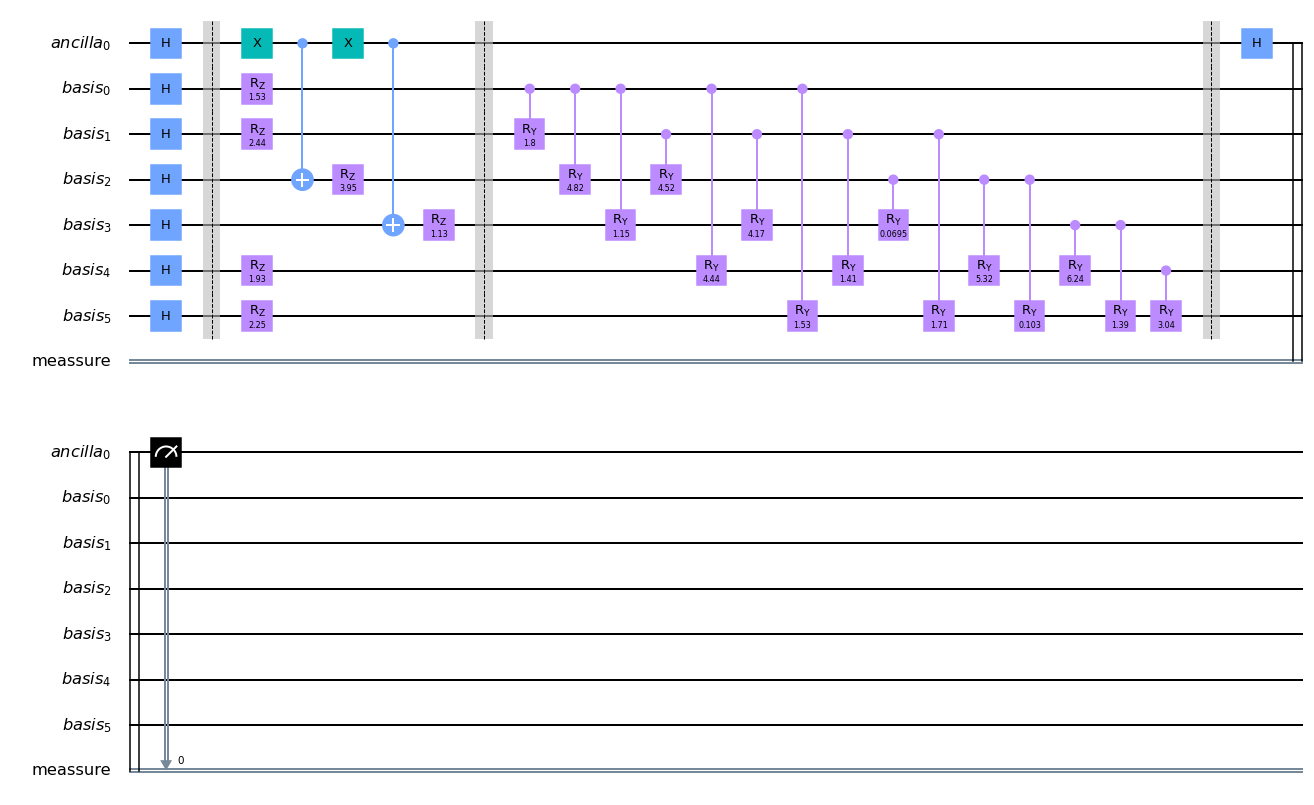

-8.881784197001252e-16

In [31]:
n=6
circ=get_circuit(n,[2,3])
values={i:np.random.uniform(0,2*np.pi) for i in circ.parameters}
circ_params=circ.assign_parameters(values)
fig,ax=plt.subplots()
circ_params.draw('mpl',ax=ax)
plt.show()

angles=np.random.uniform(0,2*np.pi,len(circ.parameters))
get_lm(circ,angles)

In [32]:
circ=get_circuit(n)

In [46]:
from scipy.signal import unit_impulse
compare=unit_impulse(2**n,20)
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
compare=gaussian(np.linspace(-1,1,2**n),0,.04)
compare/=np.linalg.norm(compare)
angles=np.random.uniform(0,2*np.pi,len(circ.parameters))
get_cost(angles,circ,compare)

1.992683461015779

In [47]:
from scipy.optimize import minimize

In [80]:
angle0=np.random.uniform(0,2*np.pi,len(circ.parameters))

bounds=[[0,2*np.pi]]*len(circ_params) 
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)

result=minimize(get_cost,angle0,method='SLSQP',args=(circ,compare),tol=1e-10)
print(result)

     fun: 1.2124243610172658
     jac: array([ 2.42888927e-06,  1.49011612e-06,  4.23192978e-06, -2.01165676e-06,
        3.57627869e-06,  2.53319740e-07,  6.36279583e-06,  3.27825546e-07,
        3.72529030e-06,  4.05311584e-06, -6.02006912e-06, -5.18560410e-06,
       -8.94069672e-07, -3.77297401e-05, -4.23192978e-06,  2.07573175e-05,
       -1.78813934e-07,  3.33786011e-06, -1.05798244e-06, -2.11596489e-06,
        2.07722187e-05])
 message: 'Iteration limit reached'
    nfev: 2200
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([ 6.28320193e+00,  4.57628776e+00,  6.28321082e+00,  4.42819890e+00,
        3.83551829e+00,  4.42661141e+00,  3.14162799e+00,  3.14158927e+00,
        4.43197909e+00,  5.20792283e+00,  6.88636327e+00, -1.71255834e+00,
       -6.34955365e-06,  4.01797559e+00, -1.66803458e+00,  2.90283576e+00,
        6.28318653e+00,  4.11885828e+00,  3.94210598e+00,  4.56837187e+00,
        4.58505880e+00])


In [81]:
from qiskit.quantum_info import state_fidelity as distance
values={i:result.x[j] for j,i in enumerate(circ.parameters)}
circ_params=circ.assign_parameters(values)
a=get_final_state(circ_params)
np.abs(np.real(a@compare.T))
# return np.arccos(distance(a,compare))
# np.arccos(distance(a,a))

0.5922415847124858

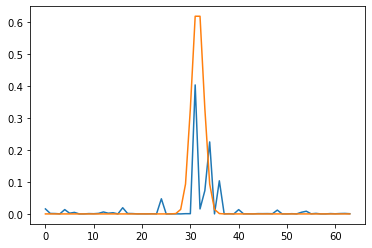

In [82]:
plt.plot(a*a.conj())
plt.plot(compare)

Trying out random circuit with differentiations

In [278]:
def get_random_circ(n,lm=None,seed=0,depth=1):

    def check_lm(lm,qubit):
        '''
        Need to check if the two qubit derivative calculatin is correct, I am sure it is not
        eq.33/34 in 1804.03023
        '''
        if cnt == lm[0]:
                circ.x(anc)
                circ.append(gates[cnt][1](),[anc,qubit])
                circ.x(anc)
        if cnt == lm[1]:
                circ.append(gates[cnt][1](),[anc,qubit])


    from qiskit.circuit.library import (YGate,CYGate,CRYGate,RYGate,XGate,CXGate,CRXGate,RXGate,ZGate,CZGate,CRZGate,RZGate)
    def get_random_gates(n,seed=0):
        import random
        random.seed(seed)
        gates=[[YGate,CYGate,CRYGate,RYGate],[XGate,CXGate,CRXGate,RXGate],[ZGate,CZGate,CRZGate,RZGate]]
        return random.choices(gates,k=n)
    anc=QuantumRegister(1,"ancilla")
    basis=QuantumRegister(n,"basis")
    meassure=ClassicalRegister(1,"meassure")
    set_ancila=1
    if lm==None:
        set_ancila=0
        lm=[-1,-1]
    if set_ancila:
        circ = QuantumCircuit(anc,basis,meassure)
        circ.h(anc)
    else:
        circ = QuantumCircuit(basis)
    combi=list(combinations(range(n),2))
    theta = [Parameter(f't-{i}') for i in range(len(combi)+n*depth)]
    gates=get_random_gates(len(theta),seed=seed)

    circ.h(basis)
    circ.barrier()

    cnt=0

    #Two qubit gates For now lets just add cnot to entangle pair wise. later on turn to paramterezed
    parameter_two_qubit=0
    if parameter_two_qubit:
        for i in combi:
            qubits=[basis[i[0]],basis[i[1]]]
            check_lm(lm,qubits[1])
            circ.append(gates[cnt][2](theta[cnt]),qubits)
            cnt+=1
        circ.barrier()
    #single qubit gates
    for _ in range(depth):
        if parameter_two_qubit==0:
            for i in combi:
                circ.cx(basis[i[0]],basis[i[1]])
            circ.barrier()
        for i in range(n):
            qubits=[basis[i]]
            check_lm(lm,qubits[0])
            circ.append(gates[cnt][3](theta[cnt]),qubits)
            cnt+=1
        circ.barrier()
    if set_ancila:
        circ.h(anc)
        circ.measure(anc,meassure)
    return circ


In [ ]:
def get_lm(circ,angles):
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    circ_params_wo_meassure=circ_params.remove_final_measurements(inplace=False)
    statevector=get_final_state(circ_params_wo_meassure)
    a=np.real(statevector*statevector.conj())
    return 1-a[0::2].sum()
def get_final_state(circ_params_wo_meassure):
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(circ_params_wo_meassure, simulator).result()
    statevector = result.get_statevector(circ_params_wo_meassure)
    return statevector
def get_cost(angles,circ,compare):
    from qiskit.quantum_info import state_fidelity as distance
    values={i:angles[j] for j,i in enumerate(circ.parameters)}
    circ_params=circ.assign_parameters(values)
    a=get_final_state(circ_params)
    # return np.abs(np.real(a@compare.T))
    # return np.arccos(distance(a,compare))
    return 2*(1-distance(a,compare))
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))



In [319]:
n=6
circ=get_random_circ(n=n,lm=None,seed=2,depth=6
)
# circ.draw()

In [345]:
compare=gaussian(np.linspace(-1,1,2**n),0,0.2)
compare/=np.linalg.norm(compare)

angle0=np.random.uniform(0,2*np.pi,len(circ.parameters))
bnds = [(0, 2*np.pi)] * len(circ.parameters)
result=minimize(get_cost,angle0,method='SLSQP',args=(circ,compare),tol=1e-7,bounds=bnds,options={"maxiter":1000})
print(result)

     fun: 0.8625865058718833
     jac: array([-2.88482010e-03, -1.67191029e-05, -2.02357769e-05,  1.73598528e-05,
        3.88920307e-06,  2.34097242e-05, -1.82837248e-05, -3.32742929e-05,
        3.54051590e-05, -2.60919333e-05, -5.25563955e-05, -1.36643648e-05,
        1.13412738e-04, -7.65025616e-05,  7.02142715e-05,  4.81307507e-06,
        3.46451998e-05,  8.72313976e-05, -8.53836536e-06, -1.82837248e-05,
        5.31077385e-05,  7.13765621e-06,  8.72313976e-05,  2.04294920e-05,
       -1.78873539e-04, -9.72449780e-05, -2.10255384e-05, -2.92956829e-05,
        1.05798244e-06, -3.69846821e-05,  4.01735306e-05, -5.33312559e-05,
        2.01165676e-06, -4.82052565e-05,  1.90436840e-05,  2.41845846e-05])
 message: 'Optimization terminated successfully'
    nfev: 2336
     nit: 63
    njev: 63
  status: 0
 success: True
       x: array([6.28318531e+00, 6.28140366e+00, 3.33053305e+00, 3.14408939e+00,
       3.14160320e+00, 0.00000000e+00, 1.58896813e+00, 9.22494071e-04,
       4.7124734

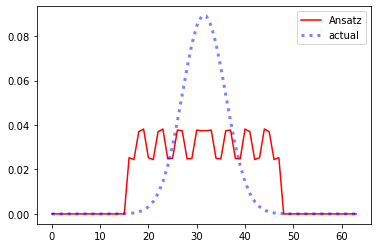

In [350]:
from qiskit.quantum_info import state_fidelity as distance
values={i:result.x[j] for j,i in enumerate(circ.parameters)}
circ_params=circ.assign_parameters(values)
a=get_final_state(circ_params)
plt.plot(a*a.conj(),label="Ansatz",c="r")
plt.plot(compare**2,lw=3,ls=":",alpha=0.5,label="actual",c="b")
plt.legend()

In [349]:
result.fun

0.8625865058718833